# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [1]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

## Support functions and variables

In [2]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [3]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [6]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


In [8]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


## Q1

### (a)

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)

     # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating   
    
    ###########         end         ###########
    return matrix

In [10]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
          if rating == 0:
            # select the row for user
            # what's the shape of userVector
            userVector = train_matrix[user, :]
            
            # Extract the items the user already rated
            ratedItems = userVector[userVector.nonzero()]
            
            # If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg
            
        # report progress every 100 users
        if (user % 100 == 0 and item == 1):
            print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]
                
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))
 
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [13]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
x = popularity_recsys.getModel()

In [15]:
np.all(x<=1)

True

In [16]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [17]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:25, 1164.34it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [0]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [20]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.61029412, 3.61029412,
        3.61029412],
       [0.        , 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [21]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:25, 1164.61it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


## Q2

### (a)

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        similarity_matrix = 1 / (1 + pairwise_distances(matrix, metric='euclidean'))
        
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
    
        similarity_matrix = 1 / (1 + pairwise_distances(matrix, metric='correlation'))
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
          # Initialize the predicted rating matrix with zeros
          temp_matrix = np.zeros(train_matrix.shape)
          temp_matrix[train_matrix.nonzero()] = 1
          uu_similarity = self.method(train_matrix)
          # UxI: UxU mul UxI
          normalizer = np.matmul(uu_similarity, temp_matrix)
          #print(normalizer)
          normalizer[normalizer == 0] = 1e-5
          #what's the dimension of np.matmul(uu_similarity, trainSet)      
          predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
          #predictionMatrix[temp_matrix.nonzero()] = 0
          #Cold start
          # if no one has rated this item before, use user average  
          useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
          columns = np.sum(predictionMatrix, axis=0)
          #print(columns.shape)
          predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)

          self.__model = predictionMatrix
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
          # Initialize the predicted rating matrix with zeros
          train_matrix = train_matrix.transpose()
          temp_matrix = np.zeros(train_matrix.shape)
          temp_matrix[train_matrix.nonzero()] = 1
          ii_similarity = self.method(train_matrix)
          # UxI: UxU mul UxI
          normalizer = np.matmul(ii_similarity, temp_matrix)
          #print(normalizer)
          normalizer[normalizer == 0] = 1e-5
          #what's the dimension of np.matmul(uu_similarity, trainSet)
          predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
          #predictionMatrix[temp_matrix.nonzero()] = 0
          #Cold start
          # if no one has rated this item before, use user average  
          itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
          columns = np.sum(predictionMatrix, axis=0)
          #print(columns.shape)
          predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)

          self.__model = predictionMatrix.transpose()
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [23]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [24]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [25]:
SimBasedRecSys.somethingelse(I)

array([[1. , 0.4, 0.4],
       [0.4, 1. , 0.4],
       [0.4, 0.4, 1. ]])

**Answer 2(a):** Cosine similarity was found to work better than the euclidean distance function. This is beacuse of the fact that cosine similarity can better handle matrix sparcity and high dimensionality. In case of euclidiean distance, the distance between 2 vectors in the same direction would drastically increase the sparcity of the matrix if the matrix is already sparse as it calculates the product of two. Whereas in the case of cosine similarity, teh angle between the two vectors is calculated and then normalized.

### (b)

In [26]:
SimBasedRecSys.somethingelse(I)

array([[1. , 0.4, 0.4],
       [0.4, 1. , 0.4],
       [0.4, 0.4, 1. ]])

**Answer 2(b):** For part b of Q2 the somethingelse() metric chosen was **Pearson Correlation**. This metric can be thought of as the cosine between the two vectors, and is therefore scale invariant. Thus, if two vectors are the same, but scaled diffently, this will be 1.

https://stackoverflow.com/questions/49894734/pearson-vs-euclidean-vs-manhattan-results

## Q3

### (a)

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [29]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [30]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [31]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:39, 1009.97it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


### (b)

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
# How to use CrossValidation Class?

In [0]:
# 1. gather your algorithms in previous steps.
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)
item_cosine_recsys.getModel()
algorithm_instances = [user_cosine_recsys, item_cosine_recsys]

In [35]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:25, 1164.97it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_rmse = CrossValidation('RMSE')

In [37]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


20000it [00:09, 2126.33it/s]
20000it [00:09, 2081.31it/s]
20000it [00:09, 2104.29it/s]
20000it [00:09, 2116.58it/s]
20000it [00:09, 2038.26it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2106.39it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2119.90it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2060.89it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2041.96it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2031.50it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135]}

In [38]:
avg_rating_user = rating_df.groupby('userID').size().to_frame(name='no_of_ratings').describe()
avg_rating_item = rating_df.groupby('itemID').size().to_frame(name='no_of_ratings').describe()
print('Average rating per user is {0} and Average rating per item is {1}'. format(avg_rating_user.loc['mean', 'no_of_ratings'], avg_rating_item.loc['mean', 'no_of_ratings']))

Average rating per user is 106.04453870625663 and Average rating per item is 59.45303210463734


**Answer 3(b):** From the above example it can be seen that **user-user** collaborative filtering for cosine similarity is a better method compared to item-item similarity. The average rating per user is 106 whereas that for item is 59 which means that more data is available for user-user based similarity to be learned.

## Q4

### (a)

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = sqrt(0.1)*np.random.randn(num_item, self.num_feat)  # item M x D 
        self.w_User = sqrt(0.1)*np.random.randn(num_user, self.num_feat)   # user N x D 
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
                pred_out = np.sum(self.w_Item[batch_ItemID] * self.w_User[batch_UserID], axis = 1) #size (batch_size, )
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(self.w_Item[train_item_idx] * self.w_User[train_user_idx], axis = 1) # size(pairs_train, )
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(self.w_Item[val_item_idx] * self.w_User[val_user_idx], axis = 1) #size(pairs_val, )
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))

        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 17, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

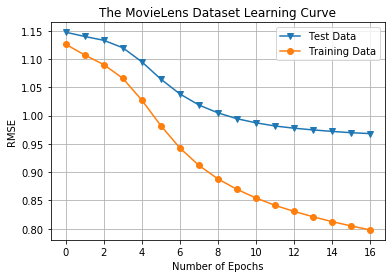

In [41]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

The **maxepoch** for pmf was found to be **17** after which it started overfitting.

## Q5

### (a)

In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances_new = [popularity_recsys, average_user_rating_recsys, user_cosine_recsys, item_cosine_recsys ,pmf]

# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
cv_rmse = CrossValidation('RMSE')
cv_patk = CrossValidation('P@K')
cv_ratk = CrossValidation('R@K')

# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.

In [43]:
cv_rmse.run(algorithm_instances_new, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2113.01it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2047.89it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2144.19it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2059.70it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2128.11it/s]


Processing algorithm useraverage


20000it [00:09, 2089.44it/s]
20000it [00:09, 2080.01it/s]
20000it [00:09, 2115.10it/s]
20000it [00:09, 2087.75it/s]
20000it [00:09, 2083.17it/s]


Processing algorithm user-cosine


20000it [00:09, 2105.34it/s]
20000it [00:09, 2096.14it/s]
20000it [00:10, 1985.66it/s]
20000it [00:09, 2133.60it/s]
20000it [00:09, 2116.51it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2068.15it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2106.96it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2101.64it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2087.89it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2148.80it/s]


Processing algorithm PMF


20000it [00:16, 1186.97it/s]
20000it [00:16, 1194.13it/s]
20000it [00:16, 1183.69it/s]
20000it [00:16, 1223.59it/s]
20000it [00:16, 1228.77it/s]


{'PMF': [[1.0190056942010868,
   1.0046638091107971,
   0.9815679584215816,
   0.9854451787178576,
   0.9961386288479123],
  0.9973642538598471,
  0.9785875504964731,
  1.016140957223221],
 'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'popularity': [[3.177941281084362,
   3.1750480150769977,
   3.147474655005899,
   3.146164503024159,
   3.1488360007536382],
  3.1590928909890112,
  3.139292746995387,
  3.1788930349826354],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135],
 'useraverage': [[1.0629951276561334,
   1.0467467492319966,
   1.0328964562995389,
   1.0366575971298078,
   1.0392923504800367],
  1.0437176561595025,
  1.0289303496379316,
  1.0585049626810734]}

In [44]:
cv_patk.run(algorithm_instances_new, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2090.84it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2128.45it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2116.00it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2143.36it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2100.36it/s]


Processing algorithm useraverage


20000it [00:09, 2113.82it/s]
20000it [00:09, 2077.13it/s]
20000it [00:09, 2099.91it/s]
20000it [00:09, 2148.50it/s]
20000it [00:09, 2090.58it/s]


Processing algorithm user-cosine


20000it [00:09, 2119.54it/s]
20000it [00:09, 2149.99it/s]
20000it [00:09, 2082.70it/s]
20000it [00:09, 2128.12it/s]
20000it [00:09, 2064.76it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2147.57it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2158.22it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2098.55it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2084.64it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2072.91it/s]


Processing algorithm PMF


20000it [00:17, 1176.23it/s]
20000it [00:16, 1212.34it/s]
20000it [00:16, 1210.64it/s]
20000it [00:16, 1204.64it/s]
20000it [00:16, 1196.78it/s]


{'PMF': [[0.3522799575821853,
   0.4822905620360565,
   0.5968186638388141,
   0.6212089077412523,
   0.6038176033934258],
  0.5312831389183468,
  0.3895957167639793,
  0.6729705610727142],
 'item-cosine': [[0.34316012725344736,
   0.483563096500532,
   0.6021208907741271,
   0.6248144220572649,
   0.6074231177094392],
  0.5322163308589621,
  0.3837005215009889,
  0.6807321402169354],
 'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'user-cosine': [[0.37179215270413657,
   0.503923647932133,
   0.621633085896077,
   0.6483563096500541,
   0.6335100742311777],
  0.5558430540827157,
  0.40959849499983714,
  0.7020876131655943],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459]}

In [45]:
cv_ratk.run(algorithm_instances_new, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2110.02it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2096.87it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2061.14it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2138.80it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2113.54it/s]


Processing algorithm useraverage


20000it [00:09, 2132.37it/s]
20000it [00:09, 2075.46it/s]
20000it [00:09, 2032.61it/s]
20000it [00:09, 2149.72it/s]
20000it [00:09, 2102.66it/s]


Processing algorithm user-cosine


20000it [00:09, 2102.45it/s]
20000it [00:09, 2095.26it/s]
20000it [00:09, 2101.32it/s]
20000it [00:09, 2076.40it/s]
20000it [00:09, 2103.44it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2080.34it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2130.22it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2113.10it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2078.73it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2115.82it/s]


Processing algorithm PMF


20000it [00:16, 1206.96it/s]
20000it [00:16, 1202.45it/s]
20000it [00:16, 1194.57it/s]
20000it [00:17, 1175.59it/s]
20000it [00:16, 1184.13it/s]


{'PMF': [[0.3302575642559974,
   0.41634241848563036,
   0.5166625009699509,
   0.5356645831520888,
   0.5489435827269848],
  0.46957412991813047,
  0.35321574802806466,
  0.5859325118081963],
 'item-cosine': [[0.3277711938444533,
   0.4237782250680911,
   0.5191391022223312,
   0.5448659224612776,
   0.5593011306991799],
  0.4749711148590666,
  0.35357317503649865,
  0.5963690546816346],
 'popularity': [[0.3466588624187514,
   0.4274468698270901,
   0.5269205125667804,
   0.5518738761026849,
   0.5674793185065369],
  0.4840758878843688,
  0.3671373629798323,
  0.6010144127889052],
 'user-cosine': [[0.34778041993806913,
   0.4314035774468209,
   0.5293633772333985,
   0.5553818201403046,
   0.5674144230096255],
  0.4862687235536437,
  0.3694473610987218,
  0.6030900860085656],
 'useraverage': [[0.30505841002027845,
   0.39554692074366876,
   0.48030412192442223,
   0.5045885853815734,
   0.5211179870422066],
  0.44132320502242983,
  0.32931026359142457,
  0.5533361464534351]}

### (b)

**Answer 5(b):** From the values above, RMSE metric cannot be used for the popularity based recommendations. This is the case because the popularity based predictions are done in the range between 0 and 1 where as the true value of the recommendations is between 0 and 5. This nature of the predicted and true values will result in high value of RMSE values. Similarly P@k and R@k does not work for useraverage recommendations as the user vector has the same value for both and hence does not play a role.

### (c)

Metric | Algorithm | Explanation
--- | --- | --- 
RMSE | PMF | The predictions are obtained by minimizing MSE(loss function)
P@K | user-cosine | This is because of higher no of user ratings
R@K | user-cosine | This is because of higher no of user ratings

### (d)
**Answer 5(d):** The ultimate goal of a recommenders system is to recommend material to a user based on his/her prefrence. A lower RMSE score is not a prerequsite for a better recommender system as after all it only depends on the ranking of the recommendations customized per user. Similarly if the RMSE is high, it means that the predicted value is far from the true value but the ranking of predicted values matter. i.e. the topK highly ranked recommendations.

## Q6

### (a)
**Answer 6(a):** 
The three movies chosen that are not so well known are:

1. Sneakers (1992)
2. Ponette (1996)
3. Eraser (1996)

In [0]:
def userTopK(moviesDataset, ratings_df, num_users, num_items, movieTitle, k):
  item_matrix = dataPreprocessor(rating_df, num_users, num_items)
  item_matrix_t = item_matrix.transpose()
  item_sim = SimBasedRecSys.cosine(item_matrix_t)
  movieID = moviesDF.loc[moviesDF['movieTitle'] == movieTitle]['movieID'].values[0]
  itemVector = item_sim[movieID-1,:]
  topK = nlargest(k+1, range(len(itemVector)), itemVector.take)
  namesTopK = list(map(lambda x: moviesDataset[moviesDataset.movieID == x+1]["movieTitle"].values[0], topK))
  return namesTopK

In [47]:
userTopK(moviesDF, rating_df, num_users, num_items, 'Sneakers (1992)', 5) 

['Sneakers (1992)',
 'Back to the Future (1985)',
 'Mrs. Doubtfire (1993)',
 'Blues Brothers, The (1980)',
 'Indiana Jones and the Last Crusade (1989)',
 'Dave (1993)']

In [48]:
userTopK(moviesDF, rating_df, num_users, num_items, 'Ponette (1996)', 5)

['Ponette (1996)',
 'Broken English (1996)',
 'Prisoner of the Mountains (Kavkazsky Plennik) (1996)',
 'Manny & Lo (1996)',
 'Substance of Fire, The (1996)',
 'Love and Other Catastrophes (1996)']

In [49]:
userTopK(moviesDF, rating_df, num_users, num_items, 'Eraser (1996)', 5)

['Eraser (1996)',
 'Mission: Impossible (1996)',
 'Independence Day (ID4) (1996)',
 'Broken Arrow (1996)',
 'Rock, The (1996)',
 'Twister (1996)']

### (b)
**Answer 6(b):** The three movies chosen were different in all aspects. The movie (Sneakers) is a mixture of 3 genres and was chosen to check the worst case scenario. It was found that as the number of genres increased, the recommendations because obscure and only 1 out of the 5 movies had 1 genre from sneakers represented in it. Whereas the other two movies had only 2 genres each and 3/4 out to the top 5 movies recommended for that category turned out to have similar genres. Hence, the recommended movies were justified not only because they had the same genre as the input but the recommended movies were also released during the same time frame as the input movies which suggests that the time era had a influence on the item similarity rated by the users and were considered popular by them suring that era.

## Q7

### (a)

Text(0.5, 1.0, 'No of Ratings vs Users')

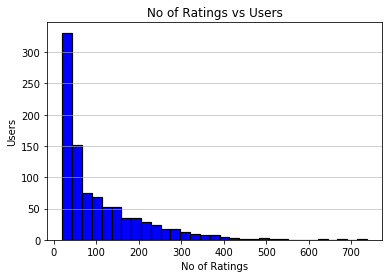

In [50]:
## Creating a histogram showing users vs the no of ratings 
rating_per_user = rating_df.groupby('userID').size().to_frame(name='no_of_ratings')
ratings_value = rating_per_user.no_of_ratings.values
plt.hist(ratings_value, bins = 'auto', color = 'blue', linewidth = 1.2, edgecolor = 'black')
plt.grid(axis='y', alpha= 0.75)
plt.ylabel('Users')
plt.xlabel('No of Ratings')
plt.title('No of Ratings vs Users')

In [0]:
count_df = rating_df.groupby('userID')['rating'].count().reset_index()

In [52]:
count_df.describe()

,userID,rating
count,943.000000,943.000000
mean,472.000000,106.044539
std,272.364951,100.931743
min,1.000000,20.000000
25%,236.500000,33.000000
50%,472.000000,65.000000
75%,707.500000,148.000000
max,943.000000,737.000000


In [0]:
below_threshold = count_df.loc[count_df['rating'] <= 65, 'userID'].reset_index().drop(['index'], axis=1)
above_threshold = count_df.loc[count_df['rating'] > 65, 'userID'].reset_index().drop(['index'], axis=1)

In [0]:
below_threshold = list(below_threshold.userID.values)
above_threshold = list(above_threshold.userID.values)

In [55]:
print(below_threshold)

[2, 3, 4, 8, 9, 12, 17, 19, 20, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 45, 46, 47, 50, 51, 52, 53, 54, 55, 61, 66, 67, 68, 69, 71, 74, 78, 79, 80, 81, 86, 88, 93, 96, 97, 98, 100, 103, 105, 106, 107, 108, 111, 112, 113, 114, 120, 122, 123, 124, 126, 127, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 146, 147, 148, 149, 150, 153, 154, 155, 156, 157, 161, 162, 163, 164, 165, 166, 169, 170, 171, 172, 173, 175, 176, 179, 180, 182, 183, 185, 187, 190, 191, 192, 196, 199, 202, 203, 204, 205, 206, 208, 209, 211, 212, 218, 219, 220, 225, 226, 227, 228, 229, 231, 237, 238, 240, 241, 242, 245, 247, 248, 252, 257, 258, 259, 260, 261, 265, 266, 272, 273, 277, 278, 281, 282, 283, 284, 285, 287, 289, 300, 302, 304, 306, 309, 310, 317, 319, 322, 329, 333, 335, 337, 340, 341, 348, 349, 350, 351, 352, 353, 355, 356, 358, 359, 362, 364, 365, 366, 367, 368, 369, 371, 375, 376, 377, 382, 384, 386, 388, 390, 395, 396, 400, 403, 404, 408, 410, 411, 412, 413, 414, 415, 418, 41

In [0]:
datasetsFileNames = [('u1.base', 'u1.test'),
                     ('u2.base', 'u2.test'),
                     ('u3.base', 'u3.test'),
                     ('u4.base', 'u4.test'),
                     ('u5.base', 'u5.test')]
fields = ['userID', 'itemID', 'rating', 'timestamp']

In [57]:
user_rmse_H = []  #empty list to store the RMSE values for higher threshold for user-user model
user_rmse_L = []  #empty list to store the RMSE values for lower threshold for user-user model

item_rmse_H = []  #empty list to store the RMSE values for higher threshold for item-item model
item_rmse_L = []  #empty list to store the RMSE values for lower threshold for item-item model

for trainFileName, testFileName in datasetsFileNames:
  curTrainDF = pd.read_csv(os.path.join(MOVIELENS_DIR, trainFileName), sep='\t', names=fields)
  curTrainDF_H = curTrainDF[curTrainDF.userID.isin(above_threshold)]
  curTrainDF_L = curTrainDF[curTrainDF.userID.isin(below_threshold)]
  curTestDF = pd.read_csv(os.path.join(MOVIELENS_DIR, testFileName), sep='\t', names=fields)
  curTestDF_H = curTestDF[curTestDF.userID.isin(above_threshold)]
  curTestDF_L = curTestDF[curTestDF.userID.isin(below_threshold)]

  #Computes the user-user similarity matrix and the RMSE values for lower and higher threshold
  user_cosine_recsys.reset()
  user_cosine_recsys.predict_all(curTrainDF_H, num_users, num_items)
  user_test_H = user_cosine_recsys.evaluate_test(curTestDF_H)
  user_cosine_recsys.reset()
  user_cosine_recsys.predict_all(curTrainDF_L, num_users, num_items)
  user_test_L = user_cosine_recsys.evaluate_test(curTestDF_L)
  rmse_H = CrossValidation.rmse(user_test_H, 5, num_users, num_items, user_cosine_recsys.getPredColName())
  rmse_L = CrossValidation.rmse(user_test_L, 5, num_users, num_items, user_cosine_recsys.getPredColName())
  user_rmse_H.append(rmse_H)
  user_rmse_L.append(rmse_L)
  
  #Computes the item-item similarity matrix and the RMSE values for lower and higher threshold
  item_cosine_recsys.reset()
  item_cosine_recsys.predict_all(curTrainDF_H, num_users, num_items)
  item_test_H = item_cosine_recsys.evaluate_test(curTestDF_H)
  item_cosine_recsys.reset()
  item_cosine_recsys.predict_all(curTrainDF_L, num_users, num_items)
  item_test_L = item_cosine_recsys.evaluate_test(curTestDF_L)
  i_rmse_H = CrossValidation.rmse(item_test_H, 5, num_users, num_items, item_cosine_recsys.getPredColName())
  i_rmse_L = CrossValidation.rmse(item_test_L, 5, num_users, num_items, item_cosine_recsys.getPredColName())
  item_rmse_H.append(i_rmse_H)
  item_rmse_L.append(i_rmse_L)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
16695it [00:08, 1992.63it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encount

In [58]:
#The following code assigns the RMSE values into a dataframe
rmse_list = []
rmse_list.append(user_rmse_H)
rmse_list.append(user_rmse_L)
rmse_list.append(item_rmse_H)
rmse_list.append(item_rmse_L)
ind = ['U_above_T', 'U_below_T', 'I_above_T', 'I_below_T']
columns = ['u1.test','u2.test','u3.test','u4.test','u5.test']
df = pd.DataFrame(rmse_list, index = ind, columns = columns)
df

,u1.test,u2.test,u3.test,u4.test,u5.test
U_above_T,1.021722,1.012073,1.007784,1.001432,1.010700
U_below_T,1.092508,1.112538,1.089666,1.098075,1.104219
I_above_T,1.042072,1.019209,1.007105,1.009677,1.018415
I_below_T,1.159161,1.145711,1.138471,1.132395,1.109249


**Answer 7(a):** Analysing the histogram and performing statistical analysis the threshold selected was **65**. This is the number of ratings that represents the median of the histogram as it is highly skewed. So users who rated below 65 represents the lower threshold and the ones above 65 represents a higher threhold.

User-user and item-item similarity was computed for both these thresholds and their respective RMSE values were assigned to a dataframe as shown above.

From the table it is seen that RMSE values are much better for users who rated above the threshold which makes sense as a higher number of ratings suggest less user-item matrix sparcity and hence a better performance by the algorithm. This prediction trend holds for both the user and item similarity algorithms. Less matrix sparcity provides more data for the model to learn and predict well.

# Validation

In [0]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [0]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [0]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [0]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [63]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [0]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUserAverRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [0]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [0]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [0]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [69]:
validateCustomizedSim()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


### User-User Similarity Based Recommendation System

In [0]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [71]:
validateUUSimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [0]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [73]:
validateIISimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide


### Probabilistic Matrix Factorization Recommendation System

In [0]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [0]:
validatePMFRecSys(validation_df=validation_df)